# First Algorithm

This notebook introduces basic Coba functionality for contextual bandit learner (algorithm) research.

## Creating a Learner

In Coba a contextual bandit learner is any class that implements the following interface.

```python
class Learner:

    @property
    def params(self) -> Dict[str,Hashable]:
        """(Optional) Return the hyperparameters for the learner."""

    def score(self, context: Context, actions: Sequence[Action], action:Action) -> float:
        """(Optional) Return the propensity score for the given action."""

    def predict(self, context: Context, actions: Sequence[Action]) -> Action | Tuple[Action,float]:
        """Choose which action to take."""

    def learn(self, context: Context, action: Action, reward: Reward, probability: float, **kwargs) -> None:
        """Learn from the results of an action in a context.""""
```

For example, below we define a new learner that we will evaluate in this notebook.

In [1]:
import coba as cb

class MyRandomLearner:
    def __init__(self,seed):
        self._rng = cb.CobaRandom(seed)
    @property
    def params(self):
        return {"seed": self._rng.seed}
    def score(self, context, actions, action) -> float:
        return 1/len(actions)
    def predict(self, context, actions):
        return self._rng.choice(actions)
    def learn(self, context, action, reward, probability):
        pass

## Debugging our Learner

Once we have a learner defined we can use Coba's synthetic datasets and baseline learners to make sure our learner is working as expected.

+ We create a simple environment with a linear reward function and a single context feature.
+ We include in our evaluation a RandomLearner, which a learner should beat if it learns anything
+ And we include a BanditUCBLearner, which we should beat if our learner is using the context features.

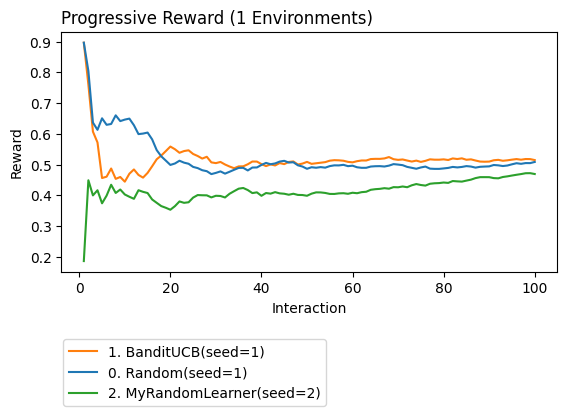

In [10]:
import coba as cb

env = cb.Environments.from_linear_synthetic(n_interactions=100, n_context_features=1, n_action_features=0, n_actions=5,seed=3)
lrn = [cb.RandomLearner(), cb.BanditUCBLearner(), MyRandomLearner(seed=2) ]

cb.Experiment(env,lrn).run(quiet=True).plot_learners()

These results seem a little odd given that `cb.RandomLearner` is doing about as well as `cb.BanditUCBLearner` and our learner is doing the worst.

To make sure this result isn't due to chance we can increase the interaction count of our environment. This will give the learners more time to learn. 

We can also add multiple random permutation of our environment to the experiment which will allow us to plot confidence intervals.

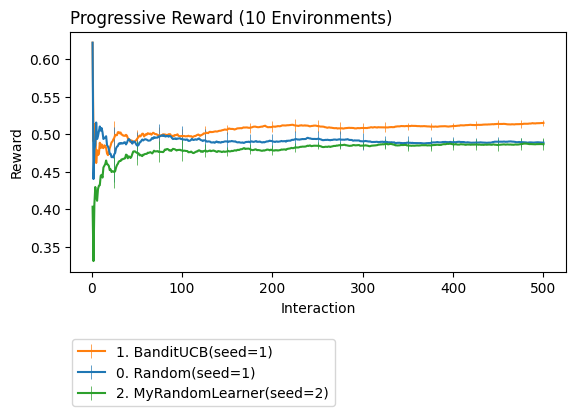

In [14]:
import coba as cb

#Increased the number of interactions from 100 to 500
env = cb.Environments.from_linear_synthetic(n_interactions=500, n_context_features=1, n_action_features=0, n_actions=5,seed=3)
lrn = [cb.RandomLearner(), cb.BanditUCBLearner(), MyRandomLearner(seed=2) ]

#Replicating our environment 10 times where the only difference between replications is the interaction order
env = env.shuffle(n=10)

cb.Experiment(env,lrn).run(quiet=True).plot_learners(err='se')

Ok, now we see that 
+ `MyRandomLearner` (defined in this notebook) is performing similarly to the baseline `cb.RandomLearner`. 
+ `cb.BanditUCBLearner` is learning a more effective strategy than randomly picking actions.

## Real Learner Performance

The toy learner we made above obviously wasn't going to do well since it just randomly selected actions. 

How about if we include a real linear contextual bandit learner? Does it outperform both the `cb.RandomLearner` and `cb.BanditUCBLearner`?

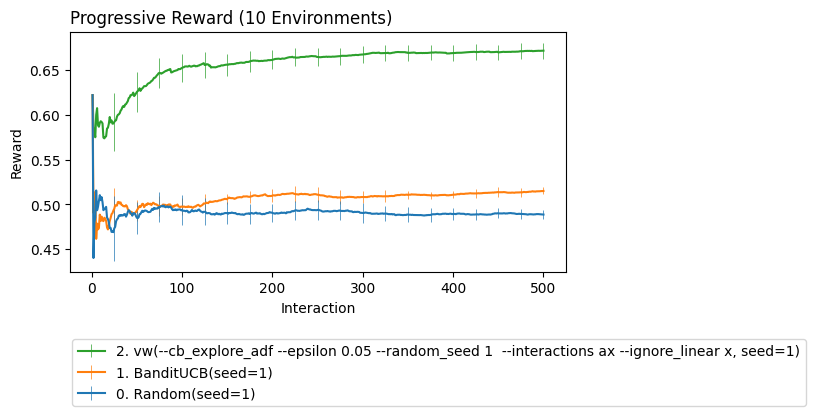

In [1]:
import coba as cb

#Increased the number of interactions from 100 to 500
env = cb.Environments.from_linear_synthetic(n_interactions=500, n_context_features=1, n_action_features=0, n_actions=5,seed=3)
lrn = [cb.RandomLearner(), cb.BanditUCBLearner(), cb.VowpalEpsilonLearner(features=(1,'a','ax')) ]

#Replicating our environment 10 times where the only difference between replications is the interaction order
env = env.shuffle(n=10)

cb.Experiment(env,lrn).run(quiet=True).plot_learners(err='se')

## Real-Data Experiment

The `cb.VowpalEpsilonLearner` looks really good on our synthetic dataset. We are ready tosee how it performs on real-world datasets.

For this experiment we're going to do the following:
1. Use the Feurer benchmark to download 240 classification datasets from openml, which coba will turn into contextual bandit environments. 
2. Save the results of our experiment to disk in case we want to look at them again later or resume the experiment if anything goes wrong.
3. Turn on multiprocessing so that Environments and Learners are evaluated in parallel up to our requested processes.

In [6]:
%%time

import coba as cb

#Given 240 different datasets things can vary quite a bit from dataset to dataset. Therefore, we limit
#ourselves to datasets with fewer than 101 features and fewer than 27 actions due to LinUCB needing to
#create a square matrix, resevoir sampling to just select 4,000 random interactions from each data set,
#and then apply feature scaling so that datasets are a little more consistent.
env = cb.Environments.from_feurer().reservoir(4000,strict=True).scale('med','iqr')
lrn = [cb.RandomLearner(), cb.BanditUCBLearner(), cb.VowpalEpsilonLearner(features=(1,'a','ax')) ]

#We're not going to do replications this time for the sake of time but
#just as we did above this could be turned on here too for a final run.
# env = env.shuffle(n=10)

# > adding a filename to the run command will save results as the experiment runs
# > adding a .gz extension to the filename will automatically compress to save space
exp = cb.Experiment(env,lrn)

#Make this True to actually run the experiment. It takes some time.
exp.run('real-data.log.gz',quiet=True,processes=12)

CPU times: total: 9.53 s
Wall time: 4min 42s
{'Learners': 3, 'Environments': 247, 'Interactions': 1428000}


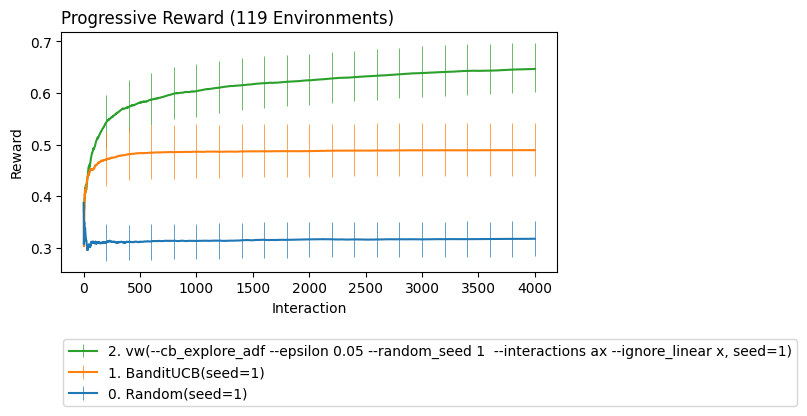

In [5]:
cb.Result.from_save('real-data.log.gz').plot_learners(err='bs')